In [41]:
#    This file is part of DEAP.
#    This implements the NSGA-II in an easy way because it makes us of DEAP subroutines
#    The non dominated sort and crowding distance are solved by a simiple call to DEAP subroutines
#    and their implementation is hidden.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import array
import random
import json
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import numpy

from math import sqrt
from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools
import matplotlib.pyplot as plt

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torchvision.__version__

#normalise pixel values (range:-1 to 1, mean:0.5, s.d:0.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size=10000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

totalImages   = len(trainloader.dataset)
miniAmount    = 1000
numOfLoaders  = totalImages // miniAmount

print("Number of loaders to create: " + str(numOfLoaders)) # 10 Loaders

miniLoaders = []

for i in range(numOfLoaders):
  startIdx        = i * miniAmount
  endIdx          = (i + 1) * miniAmount if i < numOfLoaders - 1 else totalImages
  subset          = torch.utils.data.Subset(trainset, range(startIdx, endIdx))  # Creates a subset of the whole training set
  SubTrainLoader  = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2)
  
  miniLoaders.append(SubTrainLoader)

cuda:0
Files already downloaded and verified
Files already downloaded and verified
Number of loaders to create: 50


In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

PopModel=Net()
PopModel.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
PATH = ('./40_epoch_32_batch_SGD_net.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))
final_layer = PopModel.classifier[-1]

criterion = nn.CrossEntropyLoss()
nn.init.xavier_uniform(final_layer.weight)

creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))
# creator.create("Individual", list, fitness=creator.FitnessMulti)
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMulti)
NDIM = 530
toolbox = base.Toolbox()

BOUND_LOW, BOUND_UP = -1.0, 1.0

/tmp/ipykernel_1994426/1995406619.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(final_layer.weight)


In [45]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [46]:
def evaluateModel():
    runningValLoss=0.0
    total=0.0
    PopModel.eval()
    correct_predictions=0.0
    total_samples=0.0
    correct_predictions=0.0
    # Forward pass to get predictions
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            PopModel.to(device)
            prediction = PopModel(images)
            loss=criterion(prediction, labels)
            runningValLoss=loss.item()
            _, predicted = torch.max(prediction.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100*(correct_predictions / total_samples)
    return accuracy

In [47]:
def calcFitness(individual, miniNumber):
    weights = numpy.square(numpy.array(individual))
    particleweightsNP1 = numpy.array(individual)
    particleweightsNP = particleweightsNP1[:520]
    biases = numpy.array(particleweightsNP1[-10:])
    biases = torch.from_numpy(biases).float()
    final_layer.bias = torch.nn.Parameter(biases.float())

    #converting to the correct shape
    reshapedWeights = particleweightsNP.reshape(10,52)

    #converting to torch array
    torchWeights = torch.from_numpy(reshapedWeights).float()

    #setting the weights of the final layer to these weights
    final_layer.weight = torch.nn.Parameter(torchWeights.float())

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

#     print("Calc for Individual")
    with torch.no_grad():
        for data in miniLoaders[miniNumber]:
            inputs, labels = data[0].to(device), data[1].to(device)
            PopModel.to(device)
            outputs = PopModel(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
    accuracy = 100*(correct_predictions / total_samples)
#     print(f"For entire training set, total samples: {total_samples}, correct predictions: {correct_predictions}, accuracy: {accuracy}")
    regularizer = numpy.sum(weights)

    return (accuracy, regularizer)  

In [48]:
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calcFitness)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

In [49]:
def main(seed=None):
    random.seed(seed)

    NGEN = 100
    MU =  100
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)
    miniCounter = 0
    
    #evaluating the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    print("Evaluate fitnesses before generation loop..")
    # fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    fitnesses = toolbox.map(lambda part: toolbox.evaluate(part, miniCounter), invalid_ind)

    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    #assigning crowding distance to the individuals
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    #beginning the generational process
    for gen in range(1, NGEN):
        #vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        #making pairs of all (even,odd) in offspring
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values
        
        #evaluating the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(lambda part: toolbox.evaluate(part, miniCounter), invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        #selecting the next generation population
        pop = toolbox.select(pop + offspring, MU)

        #we now have a new evolved population, the logbook can just record the highest accuracy and lowest regulariser for that generation
        #generations continue untill 100
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

        miniCounter += 1

        if miniCounter >= (len(miniLoaders)):
          miniCounter = 0
          print("Mini Counter reset!")

    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, logbook

Evaluate fitnesses before generation loop..
gen	evals	std                    	min                        	avg                        	max                        
0  	100  	[2.95619756 6.36875702]	[  4.1        162.85956577]	[ 10.036      177.13547261]	[ 17.3        191.34720495]
1  	100  	[2.73895509 6.14583123]	[  4.3       161.0917436]  	[ 12.145      173.60155201]	[ 17.7        191.02989605]
2  	100  	[2.80445431 6.84815034]	[  6.2       154.0577043]  	[ 13.506      170.21032985]	[ 19.6       184.4255577]  
3  	100  	[3.34502616 7.77713024]	[  8.        154.0577043]  	[ 15.1        167.56730174]	[ 24.         186.04654904]
4  	100  	[4.15707638 8.34219221]	[  6.3        150.39241472]	[ 15.746      165.23392408]	[ 24.         187.25198718]
5  	100  	[4.08883553 7.8429581 ]	[  6.9       149.7845254]  	[ 16.468     162.3017727]  	[ 24.9       183.5801809]  
6  	100  	[4.59672438 9.21894858]	[  6.9        146.25126613]	[ 18.005      161.00047715]	[ 26.3        186.69142264]
7  	100  	[4

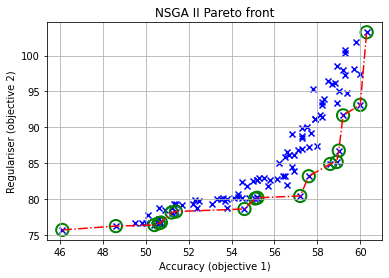

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 7.92 GiB of which 1.93 GiB is free. Including non-PyTorch memory, this process has 2.87 GiB memory in use. Process 1994428 has 2.80 GiB memory in use. Process 3083786 has 322.00 MiB memory in use. Of the allocated memory 2.68 GiB is allocated by PyTorch, and 85.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [50]:
if __name__ == "__main__":
    pop, stats = main()
    # Clone a all individual from a current popoulation
    popclone = list(map(toolbox.clone, pop))

    pop.sort(key=lambda x: x.fitness.values)
    
    # get a first non dominate individuals in all an optimal solutions
    firstFront = tools.sortNondominated(individuals=popclone,k=len(popclone), first_front_only=True)[0]
    best_weights = firstFront[0]
    # sort each individual by its ftiness values
    firstFront.sort(key= lambda x: x.fitness.values)
    popclone.sort(key = lambda x: x.fitness.values)

    # get both fitness values of each individual in an array
    # all individual
    all_fronts = numpy.array([ind.fitness.values for ind in popclone])
    # Non dominated individual
    firstFront = numpy.array([ ind.fitness.values for ind in firstFront])


    fig , (ax) = plt.subplots(ncols=1, nrows=1)
    ax.scatter(all_fronts[:,0], all_fronts[:,1], c='b', marker='x')
    ax.scatter(firstFront[:,0], firstFront[:,1], s=150, facecolor='none', edgecolors='g', linewidths=2)
    ax.plot(firstFront[:,0], firstFront[:,1], c='r', linestyle='dashdot')
    ax.set_title("NSGA II Pareto front")
    ax.set_xlabel('Accuracy (objective 1)')
    ax.set_ylabel("Regulariser (objective 2)")
    ax.grid()
    #plt.axis("tight")
    figure = ax.get_figure()
    plt.show()

    #set the weights in the model
    weights = numpy.square(numpy.array(best_weights))
    particleweightsNP1 = numpy.array(best_weights)
    particleweightsNP = particleweightsNP1[:520]
    biases = numpy.array(particleweightsNP1[-10:])
    biases = torch.from_numpy(biases).float()
    final_layer.bias = torch.nn.Parameter(biases.float())

    # Convert to the correct shape
    reshapedWeights = particleweightsNP.reshape(10,52)

    # Convert to torch array
    torchWeights = torch.from_numpy(reshapedWeights).float()

    # Set the weights of the final layer to these weights
    final_layer.weight = torch.nn.Parameter(torchWeights.float())

    #evaluate the model
    accuracy = evaluateModel()

    print("Test Accuracy: ", accuracy)

In [60]:
gen = stats.select("gen")
evals = stats.select("evals")
std = stats.select("std")
avg = [x[0] for x in stats.select("avg")]
min_fit = [x[0] for x in stats.select("min")]
max_fit = [x[0] for x in stats.select("max")]

csv_filename = "training_log_NSGA_1bounds2.csv"

with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["gen", "evals", "min", "avg", "max"])
    csv_writer.writerows(zip(gen, evals, min_fit, avg, max_fit))

print(f"Logbook exported to {csv_filename}")

Logbook exported to training_log_NSGA_1bounds2.csv


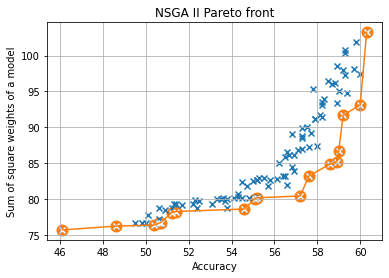

In [59]:
fig , (ax) = plt.subplots(ncols=1, nrows=1)
ax.plot(firstFront[:,0], firstFront[:,1], c='tab:orange', linestyle='solid')
ax.scatter(firstFront[:,0], firstFront[:,1], s=100, facecolor='tab:orange', edgecolors='tab:orange', linewidths=2)
ax.scatter(all_fronts[:,0], all_fronts[:,1], marker='x')
ax.scatter(firstFront[:,0], firstFront[:,1], marker='x', facecolor='w')
ax.set_title("NSGA II Pareto front")
ax.set_xlabel('Accuracy')
ax.set_ylabel("Sum of square weights of a model")
ax.grid()
figure = ax.get_figure()
plt.show()
figure.savefig("nsga-front.pdf", bbox_inches='tight')
figure.savefig("nsga-front.png", dpi=300, bbox_inches='tight')

In [ ]:
print("All fronts, ", all_fronts)
print("First front, ", firstFront)

All fronts,  [[ 39.2         77.79511142]
 [ 39.6         77.52418576]
 [ 40.2         77.95214031]
 [ 40.6         76.92386763]
 [ 40.7         77.35971864]
 [ 41.          77.16762406]
 [ 41.5         77.64465074]
 [ 41.7         77.58418739]
 [ 41.8         77.35971864]
 [ 42.1         77.68093203]
 [ 42.4         77.94813152]
 [ 42.4         78.0445908 ]
 [ 42.9         77.9279458 ]
 [ 43.3         78.009871  ]
 [ 43.7         78.25865437]
 [ 43.8         77.79511142]
 [ 44.          77.95212924]
 [ 44.3         78.90700361]
 [ 44.7         78.92381971]
 [ 44.7         79.26838068]
 [ 44.8         78.29188733]
 [ 45.8         78.94968136]
 [ 46.2         79.00950512]
 [ 46.3         79.0796237 ]
 [ 46.5         79.7317693 ]
 [ 46.6         79.72732223]
 [ 46.6         81.50074531]
 [ 46.8         79.88998073]
 [ 47.          77.94813152]
 [ 47.1         82.92756931]
 [ 47.2         79.0796237 ]
 [ 47.4         81.9557565 ]
 [ 47.5         79.03416604]
 [ 47.7         82.51683694]
 

In [56]:
csv_all_fronts = "all_fronts.csv"

with open(csv_filename, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
#     csv_writer.writerow(["gen", "evals", "std", "min", "avg", "max"])
    csv_writer.writerows(all_fronts)

print(f"Logbook exported to {csv_all_fronts}")

Logbook exported to all_fronts.csv


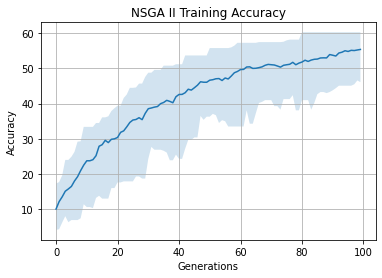

In [58]:
graphEpochCounter = range(100)
fig , (ax) = plt.subplots(ncols=1, nrows=1)
ax.fill_between(graphEpochCounter, min_fit, max_fit, alpha=0.2)
ax.plot(graphEpochCounter, avg)
ax.set_title("NSGA II Training Accuracy")
ax.set_xlabel('Generations')
ax.set_ylabel("Accuracy")
ax.grid()
figure = ax.get_figure()
plt.show()
figure.savefig("nsga-accuracy.pdf", bbox_inches='tight')
figure.savefig("nsga-accuracy.png", dpi=300, bbox_inches='tight')